# Crimes in CDMX

The purpose of this notebook is to show a deep analysis of the behavior of crimes happended in CDMX, México in years from 2014 to 2016. 

# 1. Introduction

Crimes in México is one of the most urgent concerns which it is facing. Mexico has experienced increasingly high crime rates, especially in major urban centers. The country's great economic polarization has stimulated criminal activity mainly in the lower socioeconomic strata, which include the majority of the country's population. The murder rate in 2015 was 14 per 100,000. Most of the crime is committed by a small proportion of the population involved in the drug trade with about half of murders drug related.

<img src="crime.jpeg">

# 2. Getting Started

First, we will <b>load some libraries</b> and stuff to develop our work.

In [3]:
# Contributors: 
# Fernando Lopez-Velasco
# Gerardo Last-Name
# Last update: 6/Oct/2018

# Libries to handle data
import pandas as pd
import numpy as np

# Libraries for graphs visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for maps visualization
import folium
from folium.plugins import MarkerCluster

%matplotlib inline

Second, we have been provided for two files: 

* historico_delitos_cdmx.txt: which contains historical data about crimes, dates and zones.
* catalogo_delitos.txt: catalog of crimes

In [4]:
historical = pd.read_csv("historico_delitos_cdmx.txt", sep="|")
crime_cat = pd.read_csv("catalogo_delitos.txt", sep="|")

# 3. Preparing Data

For some purposes, we need to bind both data frames which are <b>historical</b> and <b>crime_cat</b>. Binding both we will create a dataframe called <b>crimes</b>.

In [5]:
crime_cat = crime_cat.rename(columns={'ID': 'tipo_delito'}) # Rename some columns
crimes = pd.merge(historical, crime_cat, on='tipo_delito')  # Merge both data frames
crimes['FECHA'] = pd.to_datetime(crimes['FECHA'])           # Set 'FECHA' as a datatime type
crimes = crimes.set_index('FECHA')                          # Set 'FECHA' as index column
crimes = crimes.drop(['AÑO','HORA','CX','CY','MES','num_zona','tipo_delito'], axis=1) # Drop some columns
crimes.head()

,delito
FECHA,
2014-12-14,Robo a bordo de taxi c/v
2016-04-21,Robo a bordo de taxi c/v
2015-10-28,Robo a bordo de taxi c/v
2015-01-15,Robo a bordo de taxi c/v
2014-04-16,Robo a bordo de taxi c/v


For further purposes, we will extract a list of <b>crimes</b> and <b>dates</b> where crime happened.

In [6]:
crimes_list = crimes.delito.unique() # Get list of crimes
crimes_date = crimes.index.unique()  # Get list of dates

Now we need to create a new dataframe which it will going to help us to visualize some time series, this dataframe is going to be called <b>crimes_time</b>.

In [7]:
crimes_time = pd.DataFrame(columns=np.insert(crimes_list,0,'dates')) # Creating crimes_date dataframe

The next step is to fit our <b>crimes_date</b> data frame. We need that this dataframe has as index the date where crimes happend and as columns each crime. The intersection between <i>date</i> and <i>crime</i> is going to be the frecuency which crime <i>crime</i> happened at date <i>date</i>.

In [8]:
# Fitting crimes_date dataframe
for date in crimes_date:
    temporal = pd.DataFrame([['',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],columns=np.insert(crimes_list,0,'dates'))
    temporal['dates'] = date
    for crime in crimes_list:
        frecuency = crimes[(crimes.index == date) & (crimes['delito'] == crime)].shape[0]
        if frecuency > 0:
            temporal[crime] = frecuency
        else:
            temporal[crime] = 0
    crimes_time = pd.concat([crimes_time,temporal], axis='rows')

In [9]:
crimes_time['dates'] = pd.to_datetime(crimes_time['dates']) # Set 'dates' column as datatime type
crimes_time = crimes_time.set_index('dates')                # Set 'dates' as index column
crimes_time = crimes_time.astype('int32')                   # Set 'crimes_time' dataframe as 'int32' type

# 4. Time Series Visualization

In this section I will try to show you the behavior of each crime regarding specifc time.

<b>Crime regarding dates in a window from 2014 to 2016.</b>

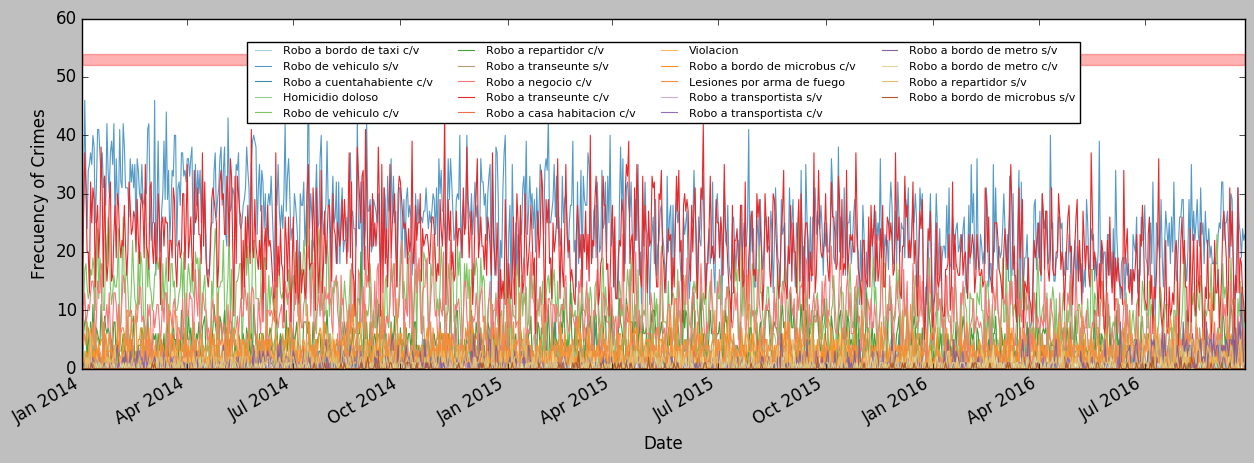

In [10]:
plt.style.use('classic')
ax = crimes_time.plot(colormap='Paired', fontsize=12, figsize=(15,5), linewidth=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Frecuency of Crimes')
ax.axhspan(crimes_time.values.max()-1, crimes_time.values.max()+1, color='red', alpha=0.3)
ax.legend(fontsize=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4, fontsize=8)
plt.show()

The horizontal red line define the top value in which case it is <b>Robo a vehículo c/v</b> with a frecuency of <b>53</b>. However it is a little confuse to understand each crime in this time series. We will proceed to split it in two groups to have a better visualization and understanding, as follows:

In [11]:
group_one = ['Violacion','Homicidio doloso','Lesiones por arma de fuego','Robo a bordo de metro c/v','Robo a bordo de metro s/v','Robo a bordo de microbus c/v','Robo a bordo de microbus s/v','Robo a bordo de taxi c/v','Robo a casa habitacion c/v']
group_two = ['Robo de vehiculo c/v','Robo de vehiculo s/v','Robo a transeunte c/v','Robo a transeunte s/v','Robo a transportista c/v','Robo a transportista s/v','Robo a cuentahabiente c/v','Robo a negocio c/v','Robo a repartidor c/v','Robo a repartidor s/v']

Now that we have splitted our orignal dataset in two parts, we will proceed to adapt the dataet to plot a better time series visualization. 

The idea is to plot each crime regarding every <b>year</b>, <b>month</b> and <b>day</b>.

In [13]:
# Getting different indexes: day, hour, minute.
index_day = crimes_time.index.day
index_month = crimes_time.index.month
index_year = crimes_time.index.year

In [25]:
crimes_time.index.month.unique()

Int64Index([12, 4, 10, 1, 6, 8, 11, 7, 5, 3, 2, 9], dtype='int64', name='dates')

Now I will define a function to plot a time serie according to each index and group.

In [26]:
# Defining a function to plot time series
def plotting(time, group):
    if time == 'year':
        tick = [2014, 2015, 2016]
        label = [2014, 2015, 2016]
        index = index_year
    elif time == 'month':
        tick = index_month.unique()
        label = ['Dec','April','Oct','Jan','Jun','Aug','Nov','July','May','March','Feb','Sep']
        #label = ['Jan','Feb', 'March','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
        index = index_month
    elif time == 'day':
        tick = index_day.unique()
        label = index_day.unique()
        index = index_day
        
    to_plot = crimes_time[group].groupby(index).mean()
    ax = to_plot.plot(colormap='Paired', fontsize=10, figsize=(12,4), linewidth=2)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Frecuency of Crimes', fontsize=10)
    plt.xticks(tick, label)
    ax.legend(fontsize=10)
    ax.legend(loc='best', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=11)
    plt.show()

## 4.1 Crimes by Year

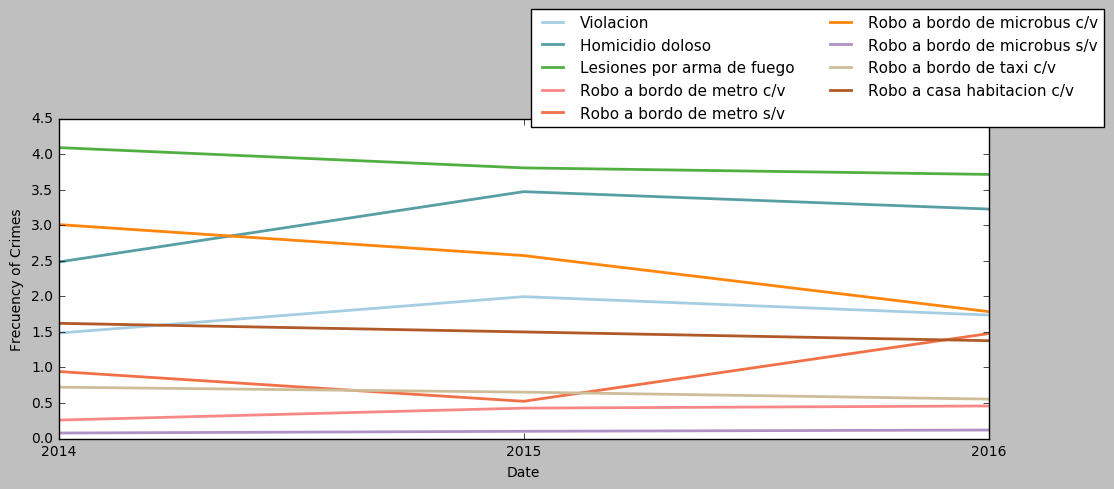

In [17]:
plotting('year',group_one)

We can look some interesting things:

* <b>Lesiones por arma de fuego</b> has the biggest frecuency and is kind of continuos among years.
* <b>Robo a bordo de metro s/v</b> has increased since 2015.

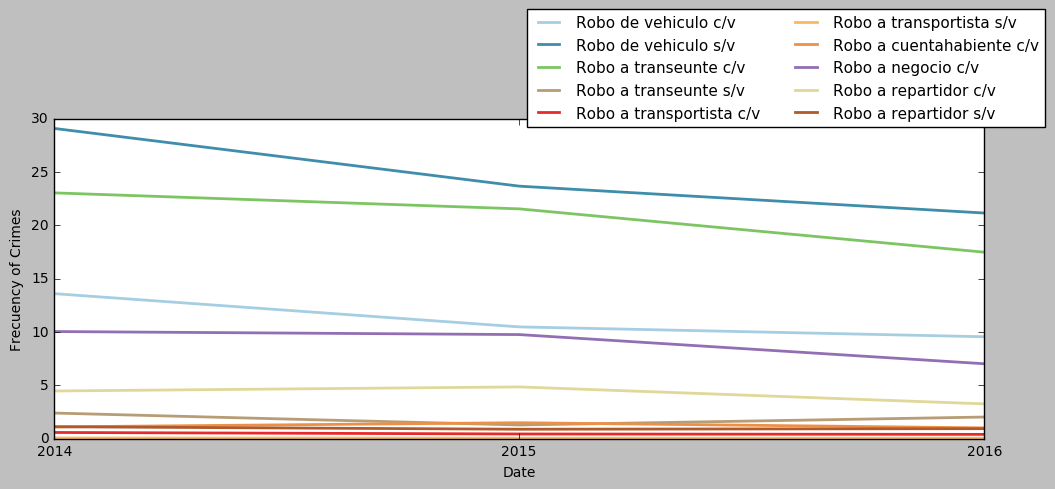

In [18]:
plotting('year', group_two)

We can look some interesting things:

* <b>Robo de vehículo s/v</b> has the biggest frecuency but it has been decresing among years as well as <b>Robo a transeunte c/v</b>.
* We can observe that <b>Robo a transportista c/v</b>, <b>Robo a transportista s/v</b> as well as <b>Robo a transeunte s/v</b> have a low frecuency but is continuos among years.

## 4.2 Crimes by Month

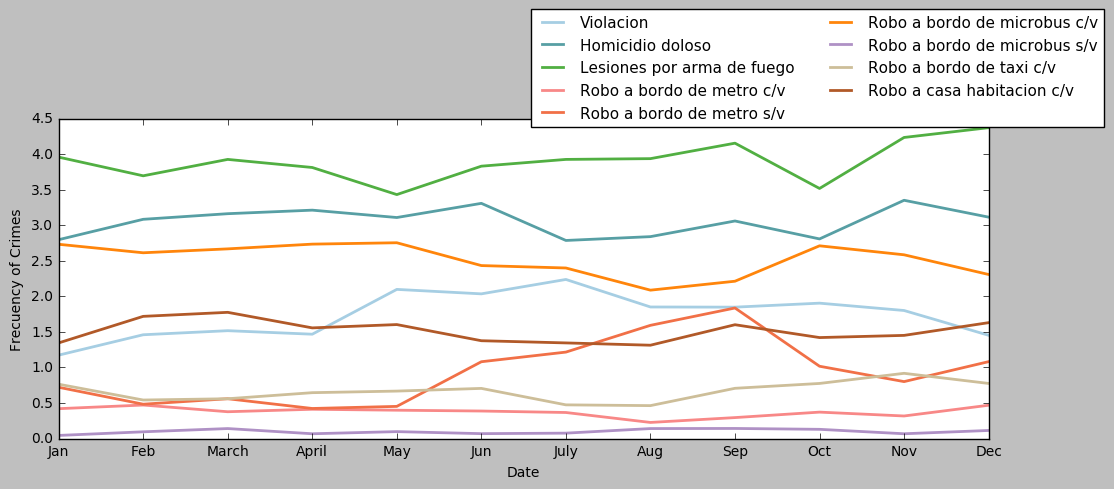

In [27]:
plotting('month', group_one)

In a more granular way, we can observe some interesting thigs:

* Between months May - September, <b>Robo a bordo de metro s/v</b> has at least an increment of 100% in occurences.
* Between months April - July, <b>Violación</b> has a increment of at least 50%.
* <b>Lesiones por arma de fuego</b> reaches its maximun point in November - December.

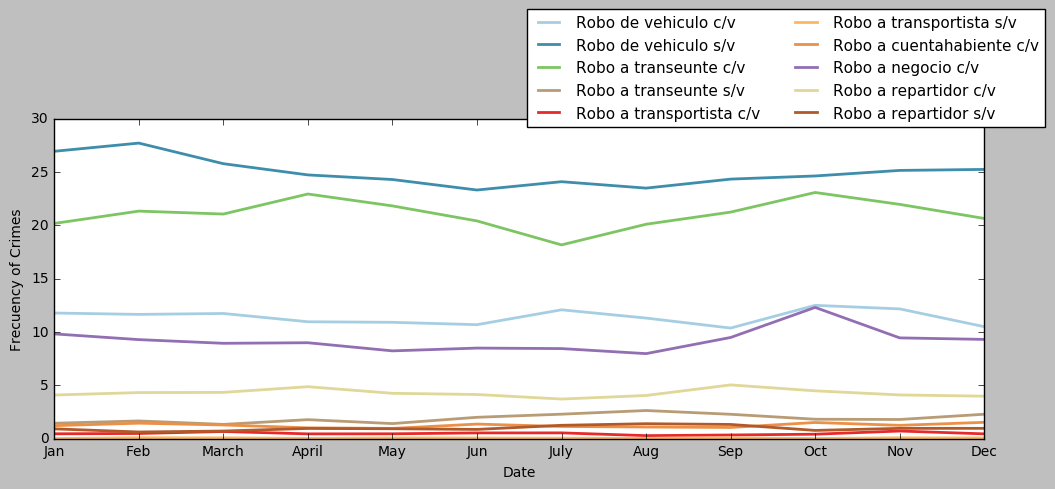

In [28]:
plotting('month', group_two)

We can observe that in October <b>Robo a negocio c/v</b> reaches its maximun point.

## 4.3 Crimes by Day

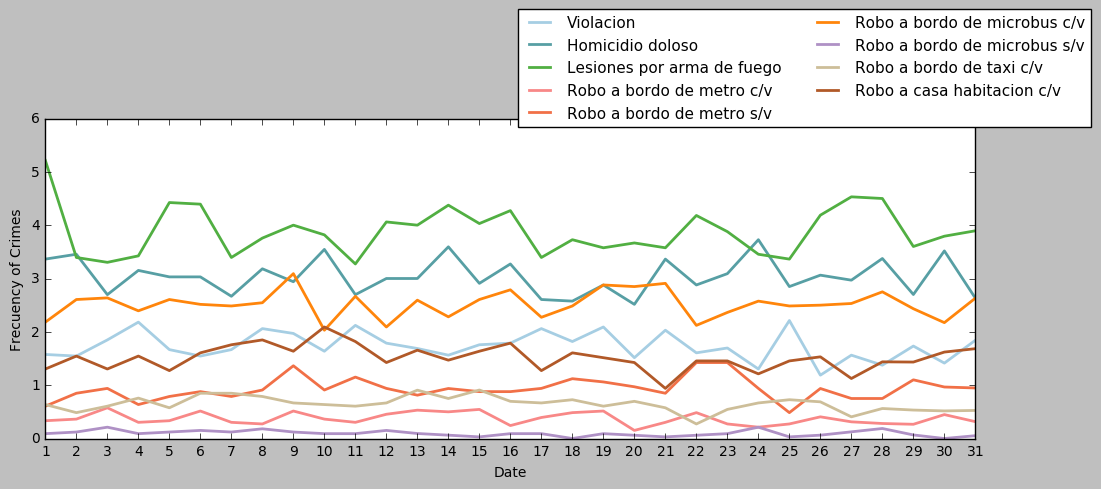

In [29]:
plotting('day', group_one)

We can observe:

* <b> Lesiones por arma de fuego</b> occurs with more frecuency in first day of month.

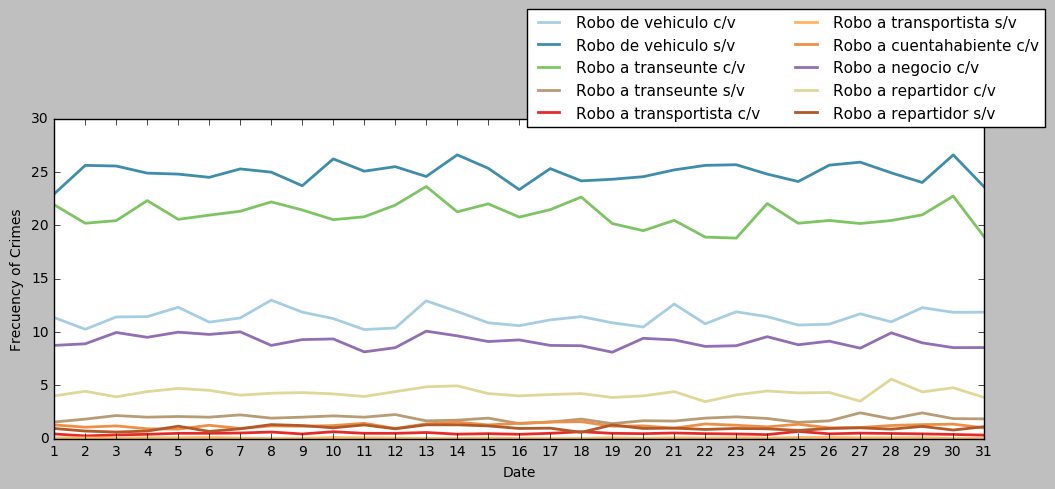

In [30]:
plotting('day', group_two)

We can observe:

* <b>Robo a transeunte c/v</b> occurs more frecuenty every fifteen days, we can think this is related to payment day.

## 4.4 Box Plot

Now let's confirm some behaviores making use of boxes plot.

<b>Plot of group one</b>

/Users/Fer/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


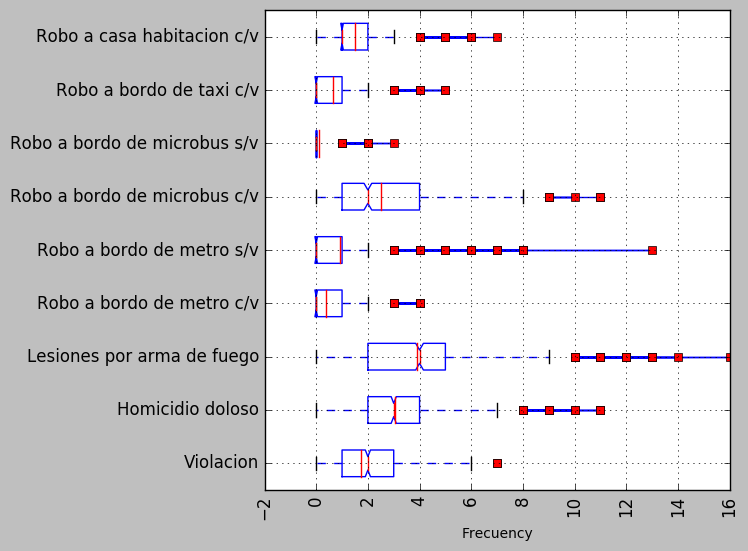

In [31]:
# Generate a boxplot
red_square = dict(markerfacecolor='r', marker='s')
ax = crimes_time[group_one].boxplot(figsize=(6,6), vert=False, meanline=True, showmeans=True, notch=True,flierprops=red_square)
ax.set_xlabel('Frecuency', fontsize=10)
plt.legend(fontsize=10)
plt.xticks(rotation=90)
plt.show()

<b>Plot of group two</b>

/Users/Fer/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


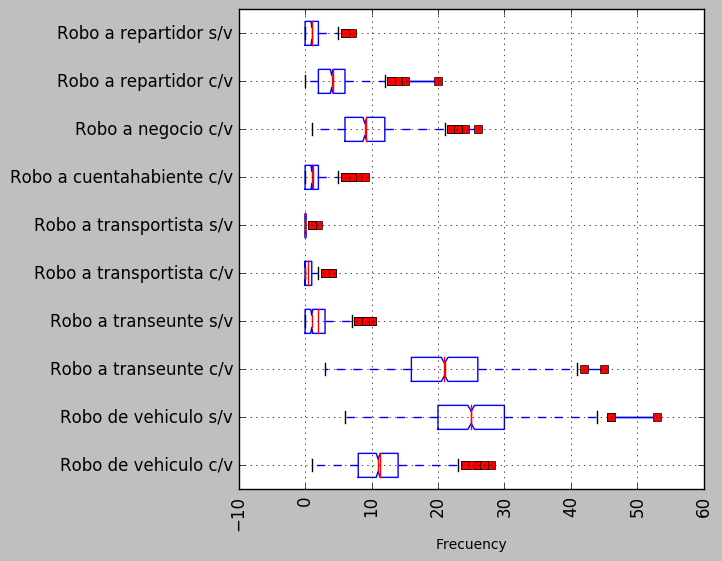

In [32]:
# Generate a boxplot
ax = crimes_time[group_two].boxplot(figsize=(6,6), vert=False, meanline=True, showmeans=True,notch=True,flierprops=red_square)
ax.set_xlabel('Frecuency', fontsize=10)
plt.legend(fontsize=10)
plt.xticks(rotation=90)
plt.show()

## 4.5 Correlations

First we will apply a correlation method based on <b>spearman</b>. This is thinking which every feature has no a linear relation between each other.

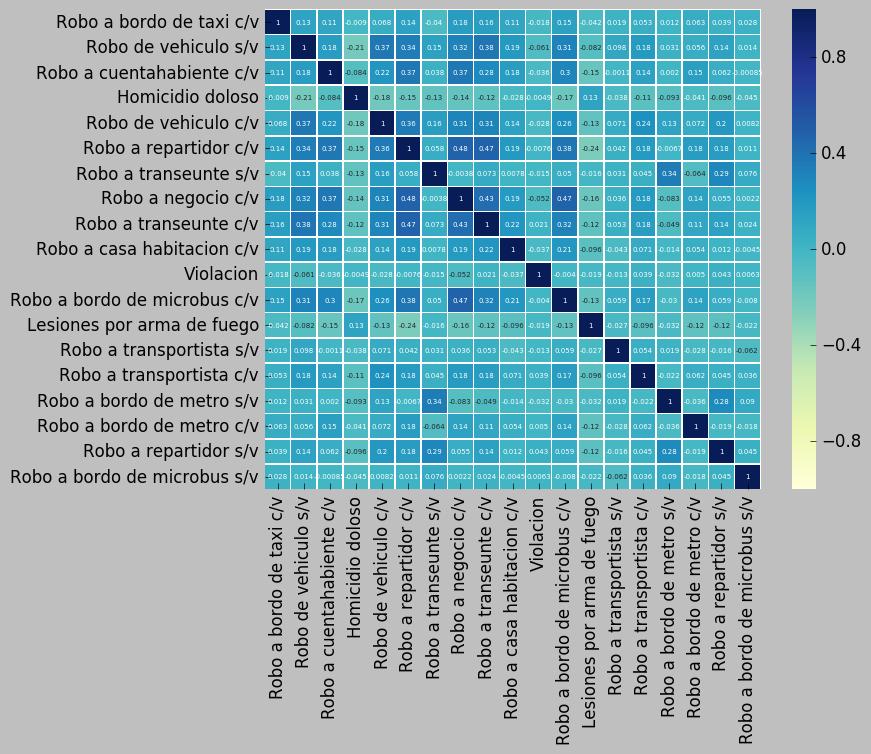

In [33]:
corr_meat = crimes_time.corr(method='spearman')
sns.heatmap(corr_meat,
            annot=True,
            linewidths=0.4,
            annot_kws={"size":5},cmap="YlGnBu")
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

Now apply another schema based on <b>pearson</b> method.

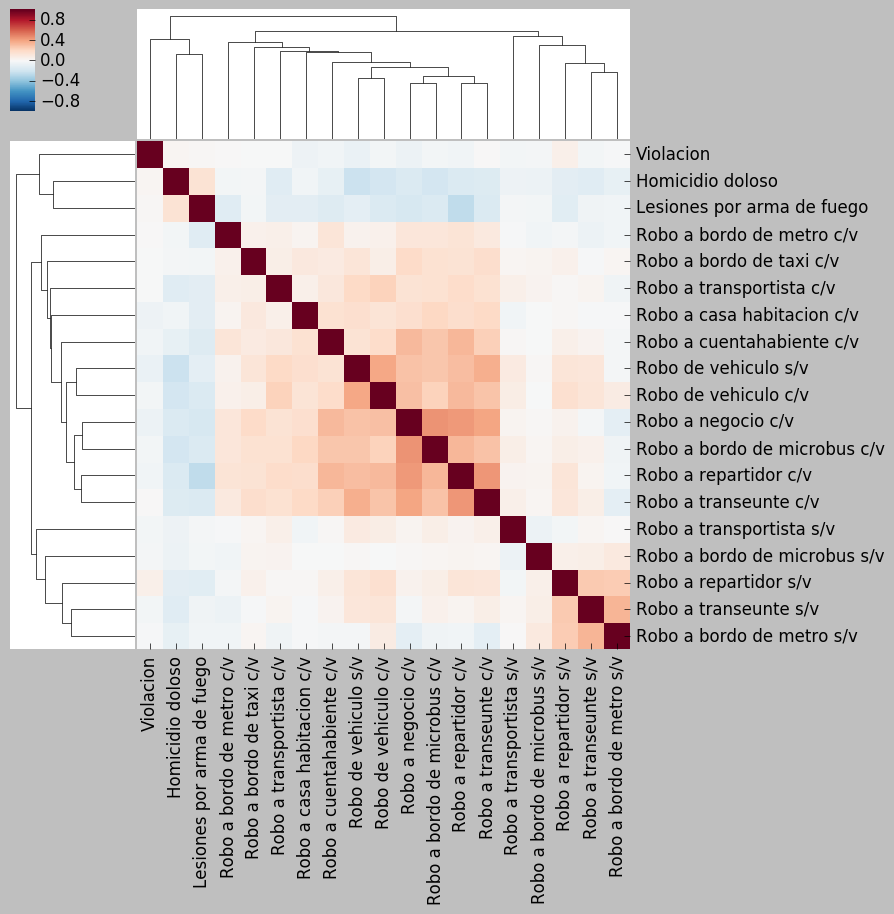

In [34]:
corr_meat = crimes_time.corr(method='pearson')
fig = sns.clustermap(corr_meat,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(8, 8))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

# 5. Geographic Visualization

In this section I will show you in a more easy way, how occur every crime in each part of CDMX.

So first we need to adapt our dataset for this purpose.

In [35]:
crimes_joined = pd.merge(historical, crime_cat, on='tipo_delito')

Let's set the <b>coordinates of CDMX</b>

In [36]:
MEXICO_COORDINATES = (19.432608, -99.133209)

Now let's set the <b>year</b> and kind of <b>crime</b> we want to visualizate.

In [37]:
Year=2014
Kind_Crime=7

<b>Let's visualize the map!</b>

In [38]:
historic_2014 = (crimes_joined[(crimes_joined['AÑO']==Year) & (crimes_joined['tipo_delito']==Kind_Crime)])

historic_map = folium.Map(location=[19.432608, -99.133209],tiles='stamentoner', zoom_start=12)

marker_cluster = MarkerCluster().add_to(historic_map)

for index,row in historic_2014.iterrows():
    folium.Marker(location=[row['CY'],row['CX']],popup=str(row['delito']),icon=None,).add_to(marker_cluster)

print("===============Map showing crime(number): "+str(Kind_Crime)+" in year "+str(Year)+"=====================")
historic_map
    

===============Map showing crime(number): 7 in year 2014=====================
